In [1]:
import pandas as pd
import json
from IPython.display import display

In [141]:
def load_data_to_df(filepath):
    with open(filepath, 'rb') as f:
        res = json.load(f)
    res = res['results']

    df = pd.concat([pd.DataFrame(r) for r in res], axis=0, keys=range(len(res)))
    df = pd.concat([df, df['hyperparam'].apply(pd.Series)], axis=1).drop(columns='hyperparam')
    df = df.rename_axis(['rollout', 'config_id'], axis='index')
    return df


def select_hparams(df, hparam_config):
    # Select results for specific hparams
    if hparam_config:
        for key, val in hparam_config.items():
            if not isinstance(val, list):
                val = [val]
            df = df[df[key].isin(val)]
    return df


def get_mean_and_sem(df, test_metric='test_risk', val_metric='val_loss', hparam_config=None):    
    if hparam_config:
        df = select_hparams(df, hparam_config)
        
    # Select best hparams
    df = df.loc[df.groupby('rollout')[val_metric].idxmin()]
    return df[test_metric].mean(), df[test_metric].sem()


# Best hparam configs
def get_best_hparam_results(df, metric='val_loss', num_best=20, hparam_config=None):
    if hparam_config:
        df = select_hparams(df, hparam_config)

    best = df.groupby('config_id').mean().sort_values(by=metric)[:num_best]
    return best

In [91]:
# Merge datasets
def load_and_merge_datasets(filepaths, property_dict=None, merge='hparam_configs'):
    if isinstance(filepaths, str):
        filepaths = [filepaths]
    
    if merge == 'rollouts':
        merge_property = 'rollout'
    elif merge == 'hparam_configs':
        merge_property = 'config_id'
    else:
        raise NotImplementedError
    
    if not property_dict:
        prop_name = 'version'
        vals = range(len(filepaths))
    else:
        prop_name = list(property_dict.keys())[0]
        vals = property_dict[prop_name]
        
    start_merge_id = 0
    dfs = []
        
    successful = 0
    for filepath, prop in zip(filepaths, vals):
        try:
            data_frame = load_data_to_df(filepath)
            data_frame = data_frame.drop(columns=['test_risk_optim', 'parameter_mse_optim', 'best_index'])
            data_frame[prop_name] = prop

            # Add new config id
            data_frame = data_frame.reset_index()
            data_frame[merge_property] += start_merge_id
            start_merge_id = data_frame[merge_property].max() + 1
            dfs.append(data_frame)
            successful += 1
        except FileNotFoundError:
            pass
            # print('File not found:', filepath)
    print(f'Found {successful}/{len(filepaths)} files.')

    df = pd.concat(dfs, ignore_index=True)
    df = df.set_index(['rollout', 'config_id'])
    return df

filepath1 = '../results/bennet_hetero/bennet_hetero_method=KMM-RF_n=2000.json'
filepath2 = '../results/bennet_hetero/bennet_hetero_method=KMM-RF_n=2000.json'
fps = [filepath1, filepath2]
property_dict = {'divergence': ['kl', 'log']}

df1 = load_data_to_df(filepath1)
df2 = load_data_to_df(filepath2)
df3 = load_and_merge_datasets(fps, property_dict)

print(get_mean_and_sem(df1))
print(get_mean_and_sem(df2))
print(get_mean_and_sem(df3))

best = get_best_hparam_results(df3, metric='test_risk')
best

df = load_and_merge_datasets('../results/bennet_hetero/bennet_hetero_method=KMM-RF_n=2000.json')
best = get_best_hparam_results(df, metric='test_risk', num_best=20)
best

In [110]:
vmm = load_and_merge_datasets("/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero/bennet_hetero_method=VMM-neural_n=2000_seed0=12345.json")
best_vmm = get_best_hparam_results(vmm, metric='val_loss',)
best_vmm

Found 1/1 files.


,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
3,0.270553,0.253146,0.819964,1.0000,0.0
2,0.239885,0.167199,0.826770,0.0100,0.0
0,0.226658,0.150483,0.828801,0.0000,0.0
1,0.235654,0.188516,0.828997,0.0001,0.0


In [204]:
fgel = load_and_merge_datasets("/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero/bennet_hetero_method=FGEL-neural_n=2000_seed0=12345.json")
best_fgel = get_best_hparam_results(fgel, metric='val_loss', hparam_config={'divergence': 'log'})
best_fgel

Found 1/1 files.


,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
11,0.187290,0.167554,0.832788,1.0000,0.0
8,0.448142,0.796722,0.908296,0.0100,0.0
2,0.473520,0.859253,0.909634,0.0000,0.0
5,0.498310,0.890296,0.918164,0.0001,0.0


In [142]:
filepaths = []

from cmr.default_config import kmm_methods

for method in kmm_methods:
    path = (f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero/'
           f'bennet_hetero_method={method}_n=2000_seed0=12345.json')
    filepaths.append(path)



In [143]:
df = load_and_merge_datasets(filepaths)

Found 805/960 files.


In [144]:
df

,,test_risk,mse,val_loss,train_stats,n_reference_samples,entropy_reg_param,reg_param,kde_bw,divergence,rkhs_func_z_dependent,val_loss_func,version
rollout,config_id,,,,,,,,,,,,
0,0,2.150613,4.481363,0.000104,"{'epochs': 240, 'val_loss': [4.348030051914975...",0,1.0,0.0,0.1,kl,True,mmr,0
1,0,0.617450,0.986612,0.000031,"{'epochs': 290, 'val_loss': [2.847321957233362...",0,1.0,0.0,0.1,kl,True,mmr,0
2,0,0.925731,1.953358,0.000097,"{'epochs': 240, 'val_loss': [6.360576662700623...",0,1.0,0.0,0.1,kl,True,mmr,0
3,0,0.726215,1.308174,0.000263,"{'epochs': 480, 'val_loss': [0.000222345101065...",0,1.0,0.0,0.1,kl,True,mmr,0
4,0,1.023722,1.838657,0.000160,"{'epochs': 240, 'val_loss': [9.713303734315559...",0,1.0,0.0,0.1,kl,True,mmr,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,804,0.103126,0.060252,0.836855,"{'epochs': 2580, 'val_loss': [0.98958665132522...",200,1000.0,10.0,0.5,log,False,moment_violation,959
6,804,0.397409,0.073729,0.855306,"{'epochs': 4820, 'val_loss': [0.96264719963073...",200,1000.0,10.0,0.5,log,False,moment_violation,959
7,804,0.110302,0.074893,0.830860,"{'epochs': 3250, 'val_loss': [0.93363767862319...",200,1000.0,10.0,0.5,log,False,moment_violation,959


In [201]:
get_best_hparam_results(df, metric='val_loss', num_best=20, 
                        hparam_config={'rkhs_func_z_dependent': 1.0,
                                       'val_loss_func': 'moment_violation',
                                       #"n_reference_samples": [200], 
                                       "entropy_reg_param": [1000],
                                       #"reg_param": [0.01],
                                       'kde_bw': 0.1,
                                       'divergence': 'kl'
                                      })

,test_risk,mse,val_loss,n_reference_samples,entropy_reg_param,reg_param,kde_bw,rkhs_func_z_dependent,version
config_id,,,,,,,,,
280,0.335088,0.306584,0.814350,0.0,1000.0,1.0000,0.1,1.0,289.0
289,0.275074,0.191916,0.818491,0.0,1000.0,10.0000,0.1,1.0,305.0
542,0.202571,0.134960,0.833492,100.0,1000.0,10.0000,0.1,1.0,625.0
528,0.197383,0.111612,0.835809,100.0,1000.0,1.0000,0.1,1.0,609.0
790,0.207112,0.100681,0.836615,200.0,1000.0,10.0000,0.1,1.0,945.0
268,0.159259,0.148795,0.843626,0.0,1000.0,0.0100,0.1,1.0,273.0
512,0.146493,0.138018,0.856906,100.0,1000.0,0.0100,0.1,1.0,593.0
760,0.139004,0.131279,0.858471,200.0,1000.0,0.0100,0.1,1.0,913.0
253,0.461166,0.769761,0.890346,0.0,1000.0,0.0001,0.1,1.0,257.0


In [189]:
get_mean_and_sem(df, test_metric='test_risk', val_metric='val_loss', hparam_config={'rkhs_func_z_dependent': 1.0,
                                       'val_loss_func': 'moment_violation',
                                       "n_reference_samples": [200], 
                                       "entropy_reg_param": [1],
                                       "reg_param": [1],
                                       'kde_bw': 0.1,
                                       'divergence': 'kl'}
                )

(0.14925202013505878, 0.030540126309839575)

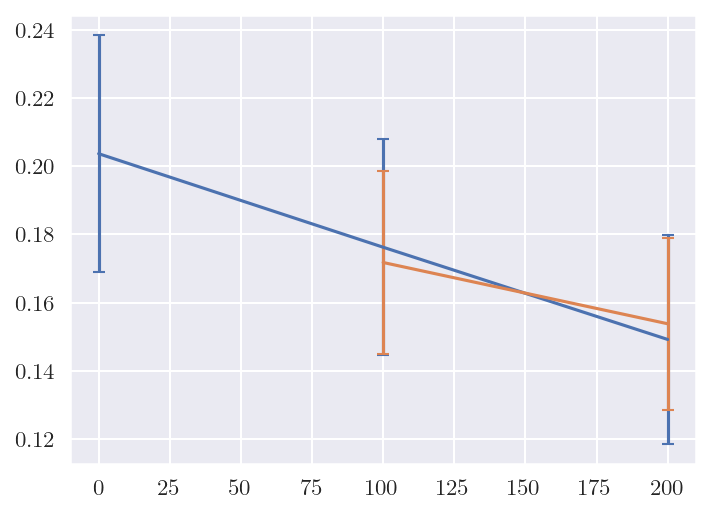

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns
from cmr.utils.plot import NEURIPS_RCPARAMS, LINE_WIDTH

plt.rcParams.update(NEURIPS_RCPARAMS)
sns.set_theme()
figsize = (LINE_WIDTH/1.3, LINE_WIDTH / 1.8)

fig, ax = plt.subplots(1, 1, figsize=figsize)

n_refs = [0, 100, 200]
for divergence in ['kl', 'log']:
    mean = []
    std = []
    for n_ref in n_refs:
        m, s = get_mean_and_sem(df, test_metric='test_risk', val_metric='val_loss', hparam_config={'rkhs_func_z_dependent': 1.0,
                                       'val_loss_func': 'moment_violation',
                                       "n_reference_samples": n_ref, 
                                       "entropy_reg_param": [1],
                                       "reg_param": [1],
                                       'kde_bw': 0.1,
                                       'divergence': divergence})
        mean.append(m)
        std.append(s)
    ax.errorbar(n_refs, mean, std)
    